In [10]:
# import modules
import random
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
from pathlib import Path
import os
cwd = os.getcwd()
import statsmodels.stats.moment_helpers
from datetime import datetime
import multiprocessing as mp
import csv
import networkx as nx

# functions

def choose_next_input(i,t,input_key):
    index1=input_keys.index(input_key)
    input_key = random.choices(input_keys,weights=grammarmat[input_keys.index(input_key)])[0]
    index2=input_keys.index(input_key)

    tprob=grammarmat[index1,index2]
    
    input = input_dict[input_key]
        
    return input, input_key, tprob


def get_acts(acts,leak,spikes,wmat,input,input_wmat,targets):
    acts = acts*leak + np.dot(input, input_wmat) + np.dot(spikes, wmat)
    
    thresholds = targets*2
    spikes[acts >= thresholds]=1
    spikes[acts < thresholds]=0
    
    acts[spikes==1]=acts[spikes==1]-thresholds[spikes==1]
    acts[acts<0]=0
       
    errors=acts-targets
    
    return acts, spikes, errors

def learning(learn_on,link_mat,prev_spikes, errors,wmat,targets):
    prev_active= np.argwhere(prev_spikes > 0)[:,0]
    prev_inactive = np.argwhere(prev_spikes<=0)[:,0]
    
    active_neighbors=link_mat.copy()
    active_neighbors[prev_inactive,:]=0
    active_neighbors=np.sum(active_neighbors,axis=0)
    
    if learn_on==1:
        d_wmat = np.zeros((nnodes,nnodes))
        d_wmat[:,:]=errors*lrate_wmat
        d_wmat[link_mat==0]=0
        d_wmat[prev_inactive,:]=0
        d_wmat=(d_wmat/active_neighbors)
        d_wmat=np.nan_to_num(d_wmat)
        wmat-=d_wmat
        
        targets=targets+(errors*lrate_targ)
        targets[targets<targ_min]=targ_min
        
    return wmat, targets

# parameter settings
nnodes=100
p_link=.1 
leak=.75 #works well
lrate_wmat=.1
lrate_targ=.01
targ_min=1
runs=500

# inputs

input_keys=['man_s','dog_s','walks_v','bites_v','dog_o','man_o','_']
input_dict = {
    'man_s':    [1,0,0,0,0],
    'dog_s':    [0,1,0,0,0],
    'walks_v':  [0,0,1,0,0],
    'bites_v':  [0,0,0,1,0],
    'dog_o':    [0,1,0,0,0],
    'man_o':    [1,0,0,0,0],
    '_':        [0,0,0,0,1]
}

grammarmat=np.zeros( (7, 7) )
grammarmat[0,2] = .75; grammarmat[0,3]=.25;
grammarmat[1,2] = .25; grammarmat[1,3]=.75;
grammarmat[2,4] = .75; grammarmat[2,5]=.25;
grammarmat[3,4] = .25; grammarmat[3,5]=.75;
grammarmat[4,6] = 1; 
grammarmat[5,6] = 1; 
grammarmat[6,0] = .5; grammarmat[6,1]=.5;

all_corrs=pd.DataFrame()
all_popcodes=pd.DataFrame()
cross_cor_matrix = np.zeros((7,7))
for run in range(runs):
    print(' ')
    print(run)

    #input mat
    input_wmat=np.zeros((5,nnodes))
    for row in range(input_wmat.shape[0]):
        for col in range(nnodes):
            input_wmat[row,col]=random.choices([0,5], weights=(1-p_link,p_link), k=1)[0]

    #internal weight matrix
    link_mat = np.zeros((nnodes,nnodes))
    for row in range(link_mat.shape[0]):
        for col in range(link_mat.shape[1]):
            if row == col:
                continue
            link_mat[row,col] = random.choices([0,1], weights=(1-p_link,p_link), k=1)[0]

    wmat=np.zeros((nnodes,nnodes))
    for row in range(wmat.shape[0]):
        for col in range(wmat.shape[1]):
            if link_mat[row,col] == 1:
                wmat[row,col] = np.random.normal(0,1)

    start_wmat=wmat.copy()

    # run the model
    end_spikes=pd.DataFrame()
    end_acts=pd.DataFrame()
    end_targets=pd.DataFrame()
    end_stream=pd.DataFrame()
    end_errors=pd.DataFrame()
    end_tprobs=pd.DataFrame()

    spikes=np.zeros(nnodes)
    targets=np.repeat(targ_min,nnodes)
    acts=np.zeros(nnodes)

    input_key = '_'

    i=1
    t=0
    learn_on=1
    check=np.zeros(7)
    while sum(check)<14:
        t+=1

        input, input_key, tprob = choose_next_input(i,t,input_key)
        if input_key=='man_s':
            if check[0]<2:
                check[0]+=1
        if input_key=='dog_s':
            if check[1]<2:
                check[1]+=1
        if input_key=='walks_v':
            if check[2]<2:
                check[2]+=1
        if input_key=='bites_v':
            if check[3]<2:
                check[3]+=1
        if input_key=='dog_o':
            if check[4]<2:
                check[4]+=1
        if input_key=='man_o':
            if check[5]<2:
                check[5]+=1
        if input_key=='_':
            if check[6]<2:
                check[6]+=1

        prev_spikes = spikes.copy()

        acts, spikes, errors = get_acts(acts,leak,spikes,wmat,input,input_wmat,targets)

        if ((i % 1000 ==0) | (i == 1)) & (t==1):
            print('   ', i)

        wmat,targets = learning(learn_on,link_mat,prev_spikes, errors, wmat,targets)

        
        end_spikes=end_spikes.append([spikes], ignore_index=True)
        end_acts=end_acts.append([acts], ignore_index=True)
        end_errors=end_errors.append([errors], ignore_index=True)
        end_stream=end_stream.append([input_key], ignore_index=True)
        end_tprobs=end_tprobs.append([tprob], ignore_index=True)
        end_targets=end_targets.append([targets], ignore_index=True)

        if t == 4:
            t=0
            i+=1

    end_wmat=wmat.copy()
    
    #check for pop. codes
    pop_codes=[]
    for word in input_keys:
        arr=np.array(end_spikes)[np.argwhere(np.array(end_stream)[:,0]==word)[:,0],:]
        n=arr.shape[0]
        cor_matrix = np.zeros((n,n))
        for i in range(n):
            spikes1=arr[i,:]
            for j in range(n):
                spikes2=arr[j,:]
                corr = np.around(scipy.stats.pearsonr(spikes1, spikes2)[0],2)
                cor_matrix[i,j]=corr
        pop_codes.append(cor_matrix.mean())
    all_popcodes=all_popcodes.append(pd.DataFrame(np.concatenate(([run],pop_codes))).T)
    
    #cross-corrs
    avg_man_s=np.array(end_spikes)[np.argwhere(np.array(end_stream)[:,0]=='man_s')[:,0],:].mean(axis=0)
    avg_dog_s=np.array(end_spikes)[np.argwhere(np.array(end_stream)[:,0]=='dog_s')[:,0],:].mean(axis=0)
    avg_walks_v=np.array(end_spikes)[np.argwhere(np.array(end_stream)[:,0]=='walks_v')[:,0],:].mean(axis=0)
    avg_bites_v=np.array(end_spikes)[np.argwhere(np.array(end_stream)[:,0]=='bites_v')[:,0],:].mean(axis=0)
    avg_dog_o=np.array(end_spikes)[np.argwhere(np.array(end_stream)[:,0]=='dog_o')[:,0],:].mean(axis=0)
    avg_man_o=np.array(end_spikes)[np.argwhere(np.array(end_stream)[:,0]=='man_o')[:,0],:].mean(axis=0)
    avg_spc=np.array(end_spikes)[np.argwhere(np.array(end_stream)[:,0]=='_')[:,0],:].mean(axis=0)

    avg_array=([avg_man_s,avg_dog_s,avg_walks_v,avg_bites_v,avg_dog_o,avg_man_o,avg_spc])

    for i in range(7):
        arr1=avg_array[i]
        for j in range(i,7):
            arr2=avg_array[j]
            corr = np.around(scipy.stats.pearsonr(arr1, arr2)[0],2)
            cross_cor_matrix[j,i]=cross_cor_matrix[j,i]+corr

    #testing
    learn_on = 1
    for first_input in ['man_s','dog_s']:
        for second_input in ['NA','walks_v','bites_v']:

            spikes=np.array(end_spikes.iloc[end_spikes.shape[0]-1,:])

            acts=np.array(end_acts.iloc[end_acts.shape[0]-1,:])       
            wmat=end_wmat.copy()

            on=True
            while on==True:

                input_key = first_input
                input = input_dict[input_key]

                prev_spikes = spikes.copy()
                acts, spikes, errors = get_acts(acts,leak,spikes,wmat,input,input_wmat,targets)
                wmat,targets = learning(learn_on,link_mat,prev_spikes, errors,wmat,targets)

                if(second_input=='NA'):
                    on=False
                else:
                    input_key = second_input
                    input = input_dict[input_key]

                    prev_spikes = spikes.copy()
                    acts, spikes, errors = get_acts(acts,leak,spikes,wmat,input,input_wmat,targets)
                    wmat,targets = learning(learn_on,link_mat,prev_spikes, errors,wmat,targets)
                    on=False

            prev_spikes = spikes.copy()
            input=[0,0,0,0,0]
            acts, spikes, errors = get_acts(acts,leak,spikes,wmat,input,input_wmat,targets)

            results=[]
            for i in range(7):
                word=input_keys[i]
                arr=np.array((end_spikes.iloc[end_stream.index[end_stream[0] == word],:]))
                corrs=[]
                for n in range(arr.shape[0]):
                    x = arr[n,:]
                    corr = np.around(scipy.stats.pearsonr(x, spikes)[0],2)
                    corrs.append(corr)
                res=np.mean(corrs)
                results.append(res)

    #         results=(results - np.min(results)) / (np.max(results) - np.min(results))
    #         results=results/sum(results)
            all_corrs=all_corrs.append(pd.DataFrame(np.concatenate(([run,first_input,second_input],results))).T)

cross_cor_matrix=cross_cor_matrix/runs
cross_cor_matrix=pd.DataFrame(cross_cor_matrix)
cross_cor_matrix.to_csv('cross_corr_matrix_start.csv')
all_popcodes.rename(columns = {0: 'run', 1: input_keys[0], 2:input_keys[1], 3:input_keys[2], 4:input_keys[3], 5:input_keys[4], 6:input_keys[5],7:input_keys[6]}, inplace = True)
all_popcodes.to_csv('all_popcodes_start.csv')
all_corrs.rename(columns = {0: 'run',1:'first_input', 2: 'second_input', 3: input_keys[0],4:input_keys[1],5:input_keys[2],6:input_keys[3],7:input_keys[4],8:input_keys[5],9:input_keys[6]}, inplace = True)
all_corrs.to_csv('all_corrs_start.csv')

 
0
    1


/Users/jbenfalandays/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


 
1
    1
 
2
    1
 
3
    1
 
4
    1
 
5
    1
 
6
    1
 
7
    1
 
8
    1
 
9
    1
 
10
    1
 
11
    1
 
12
    1
 
13
    1
 
14
    1
 
15
    1
 
16
    1
 
17
    1
 
18
    1
 
19
    1
 
20
    1
 
21
    1
 
22
    1
 
23
    1
 
24
    1
 
25
    1
 
26
    1
 
27
    1
 
28
    1
 
29
    1
 
30
    1
 
31
    1
 
32
    1
 
33
    1
 
34
    1
 
35
    1
 
36
    1
 
37
    1
 
38
    1
 
39
    1
 
40
    1
 
41
    1
 
42
    1
 
43
    1
 
44
    1
 
45
    1
 
46
    1
 
47
    1
 
48
    1
 
49
    1
 
50
    1
 
51
    1
 
52
    1
 
53
    1
 
54
    1
 
55
    1
 
56
    1
 
57
    1
 
58
    1
 
59
    1
 
60
    1
 
61
    1
 
62
    1
 
63
    1
 
64
    1
 
65
    1
 
66
    1
 
67
    1
 
68
    1
 
69
    1
 
70
    1
 
71
    1
 
72
    1
 
73
    1
 
74
    1
 
75
    1
 
76
    1
 
77
    1
 
78
    1
 
79
    1
 
80
    1
 
81
    1
 
82
    1
 
83
    1
 
84
    1
 
85
    1
 
86
    1
 
87
    1
 
88
    1
 
89
    1
 
90
    1
 
91
    1
 
92
   

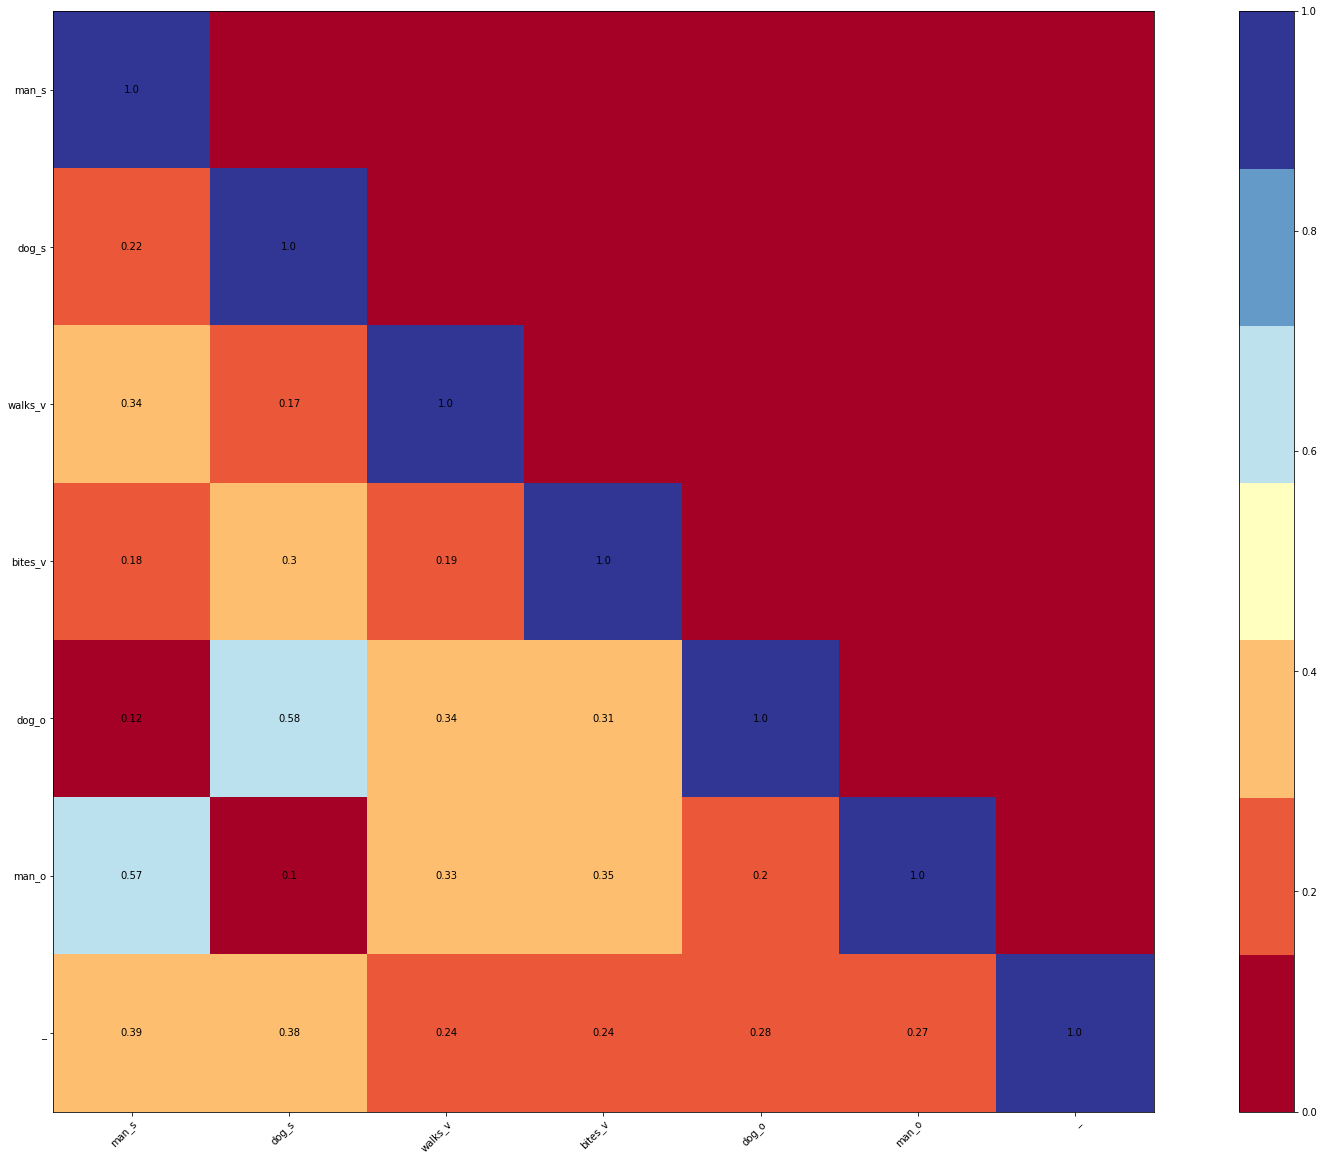

In [9]:
cross_cor_matrix=np.array(cross_cor_matrix)
cmap = cm.get_cmap('RdYlBu', 7)

fig, ax = plt.subplots()
im = ax.imshow(cross_cor_matrix,cmap=cmap)

ax.set_xticks(np.arange(7))
ax.set_yticks(np.arange(7))

ax.set_xticklabels(input_keys)
ax.set_yticklabels(input_keys)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(7):
    for j in range(7):
        if j > i:
            continue
        text = ax.text(j, i, np.around(cross_cor_matrix[i, j],2),
                       ha="center", va="center", color="black")

#name='Fig3.'+ str(input_keys[first_input]) + '.' + str(input_num) +'.png'

plt.colorbar(im, ax=ax)
fig.tight_layout()
fig.set_size_inches(25, 20)
#fig.savefig(name, dpi=100)

plt.show()